# Q1

In [50]:
import timeit
import csv
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import spacy
import string
from multiprocessing import Pool, cpu_count
from string import punctuation
import statsmodels.api as sm

In [63]:
from sklearn.feature_extraction import _stop_words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
import nltk

In [48]:
#from gensim import corpora, models
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
#from sklearn.lda import LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
import seaborn as sns

In [8]:
small_df = pd.read_csv("D:/Angie/Grad in UWaterloo/Term 2 W24/ECON626/Prediction Competition/FinalPC/MLforEcon_small_training_with_quotes_FinalPC_v3.csv")

In [25]:
small_df.head()

,overall_rating,firm,date_review,job_title,location,headline,pros,cons,year
0,1,WLT-Group,2017-11-20,Team Leader,"Stevenage, England, England",Avoid these idiots,you can leave at any time,no payrises\rno incentive to do well\rIf you d...,2017
1,1,ASDA,2019-09-02,Home Delivery Driver,"Dundonald, Northern Ireland, Northern Ireland",Gack pure and utter,"Leaving the store, customers were great even w...","Poor management, awful attitude to they're staff",2019
2,1,McDonald-s,2019-09-26,Manager,"Dallas, TX",bad pay for how much work i put in,you can steal fries when nobodies looking,if you get caught punishment,2019
3,1,Adecco,2014-12-09,Technical Lead for IBM,Bangalore,Irresponsible company after joining,Nothing positive about this company,1)After joining and deployed to client locatio...,2014
4,1,Grant-Thornton,2020-10-20,Senior Associate,NaN,Discriminate against women in Cyber Risk,The initial pay is what draws you in,This is a place where boys club goes to a whol...,2020


In [32]:
small_df.info()
# We can see that no missing value in overall_rating
# 250 null values in headlinie
# 2 null values in cons

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   overall_rating  100000 non-null  int64 
 1   firm            100000 non-null  object
 2   date_review     100000 non-null  object
 3   job_title       100000 non-null  object
 4   location        64456 non-null   object
 5   headline        99750 non-null   object
 6   pros            100000 non-null  object
 7   cons            99998 non-null   object
 8   year            100000 non-null  int64 
dtypes: int64(2), object(7)
memory usage: 6.9+ MB


In [41]:
# I want to combine all headline, pros, and cons into one, name it review, for text analysis
# There are null values in headline and cons, and I still want to concatenate the strings even if it's a null cell
small_df['review'] = small_df['headline'].fillna('') + ' ' + small_df['pros'].fillna('') + ' ' + small_df['cons'].fillna('')
small_df.info()
small_df.head()
# Now I have the df with the whole review.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   overall_rating  100000 non-null  int64 
 1   firm            100000 non-null  object
 2   date_review     100000 non-null  object
 3   job_title       100000 non-null  object
 4   location        64456 non-null   object
 5   headline        99750 non-null   object
 6   pros            100000 non-null  object
 7   cons            99998 non-null   object
 8   year            100000 non-null  int64 
 9   review          100000 non-null  object
dtypes: int64(2), object(8)
memory usage: 7.6+ MB


,overall_rating,firm,date_review,job_title,location,headline,pros,cons,year,review
0,1,WLT-Group,2017-11-20,Team Leader,"Stevenage, England, England",Avoid these idiots,you can leave at any time,no payrises\rno incentive to do well\rIf you d...,2017,Avoid these idiots you can leave at any time n...
1,1,ASDA,2019-09-02,Home Delivery Driver,"Dundonald, Northern Ireland, Northern Ireland",Gack pure and utter,"Leaving the store, customers were great even w...","Poor management, awful attitude to they're staff",2019,"Gack pure and utter Leaving the store, custome..."
2,1,McDonald-s,2019-09-26,Manager,"Dallas, TX",bad pay for how much work i put in,you can steal fries when nobodies looking,if you get caught punishment,2019,bad pay for how much work i put in you can ste...
3,1,Adecco,2014-12-09,Technical Lead for IBM,Bangalore,Irresponsible company after joining,Nothing positive about this company,1)After joining and deployed to client locatio...,2014,Irresponsible company after joining Nothing po...
4,1,Grant-Thornton,2020-10-20,Senior Associate,NaN,Discriminate against women in Cyber Risk,The initial pay is what draws you in,This is a place where boys club goes to a whol...,2020,Discriminate against women in Cyber Risk The i...


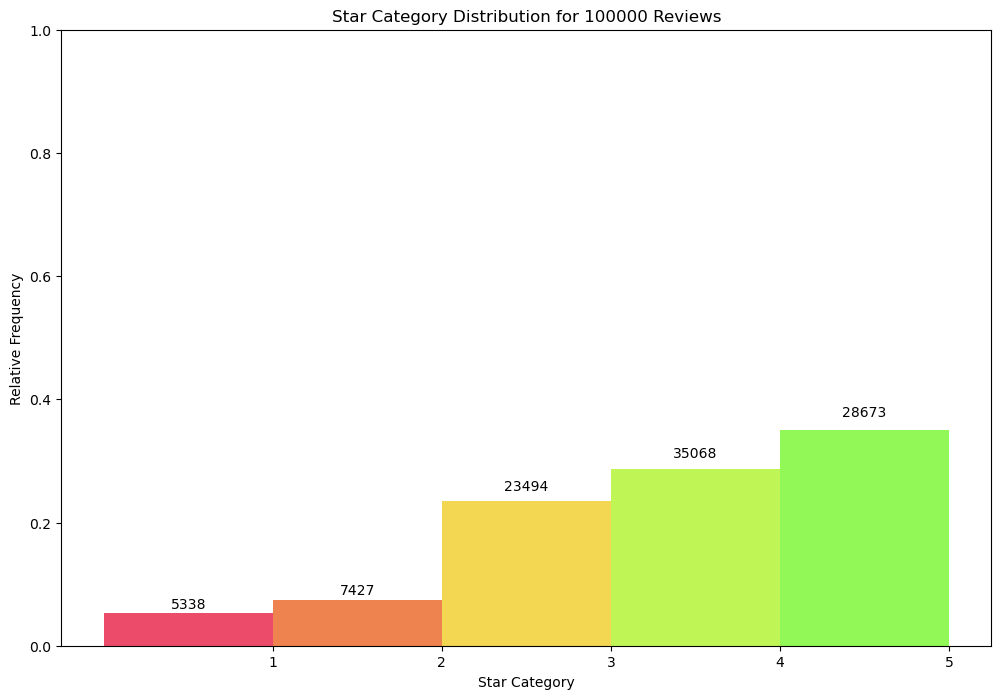

In [31]:
# How are the stars distributed over reviews?
N_star_categories = 5
colors = np.array(['#E50029', '#E94E04', '#EEC708', '#A5F30D', '#62F610']) # 1, 2, 3, 4, and 5 stars respectively
stars_labels = np.array([x_stars+1 for x_stars in range(N_star_categories)])
star_category_dist_fig = plt.figure(figsize=(12,8))
bar_plot_indices = np.arange(N_star_categories)
star_category_absolute_frequencies = small_df.overall_rating.value_counts(ascending=True)
star_category_relative_frequencies = np.array(star_category_absolute_frequencies)/float(sum(star_category_absolute_frequencies))

rects = plt.bar(bar_plot_indices, star_category_relative_frequencies, width=1, color=colors, alpha=.7)
for (idx, rect) in enumerate(rects):
        plt.gca().text(rect.get_x()+rect.get_width()/2., 1.05*rect.get_height(), '%d'%int(star_category_absolute_frequencies[idx+1]),
                ha='center', va='bottom')


plt.xticks(bar_plot_indices+.5, stars_labels)
plt.xlabel('Star Category')
plt.ylabel('Relative Frequency')
plt.ylim([0,1])
plt.title('Star Category Distribution for {0} Reviews'.format(len(small_df)))

plt.show()

# We can see that most reviews are good ratings (rating between 3-5)

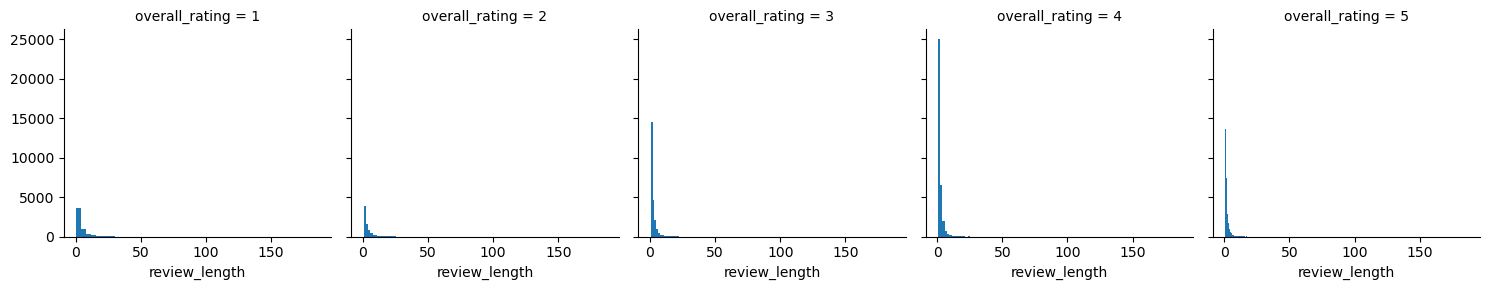

In [47]:
# How is the length of review related to Star Rating?
small_df['review_length'] = (small_df['review'].str.len())/100
review_length_distribution = sns.FacetGrid(data=small_df, col='overall_rating')
review_length_distribution.map(plt.hist, 'review_length', bins=50)

#Distribution of text length is similar across all five ratings. But number of reviews seems to be skewed a lot higher towards the 4-star and 5-star ratings

In [51]:
# I want to clean the review text
def CleanText(text):
    #Remove punctuation while tokenizing
    tokenizer = RegexpTokenizer(r'\w+')
    allTokens = tokenizer.tokenize(text)
    #Remove stop words
    tokens = [token for token in allTokens if token not in stopwords.words('english')]
    #lower case
    tokens = [token.lower() for token in tokens]
    #Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    #Create a text string from the token list
    text = ''
    for token in tokens:
        text = text + token + ' '
    return text

In [52]:
%%time
#clean every row
small_df['cleaned_review'] = small_df['review'].apply(CleanText)


CPU times: total: 17min 21s
Wall time: 18min 50s


In [54]:
small_df.to_excel('D:/Angie/Grad in UWaterloo/Term 2 W24/ECON626/Prediction Competition/FinalPC/small_training_with_cleaned_review.xlsx', index=True)

In [60]:
small_df.head()

,overall_rating,firm,date_review,job_title,location,headline,pros,cons,year,review,review_length,cleaned_review
0,1,WLT-Group,2017-11-20,Team Leader,"Stevenage, England, England",Avoid these idiots,you can leave at any time,no payrises\rno incentive to do well\rIf you d...,2017,Avoid these idiots you can leave at any time n...,1.45,avoid idiot leave time payrises incentive well...
1,1,ASDA,2019-09-02,Home Delivery Driver,"Dundonald, Northern Ireland, Northern Ireland",Gack pure and utter,"Leaving the store, customers were great even w...","Poor management, awful attitude to they're staff",2019,"Gack pure and utter Leaving the store, custome...",1.54,gack pure utter leaving store customer great e...
2,1,McDonald-s,2019-09-26,Manager,"Dallas, TX",bad pay for how much work i put in,you can steal fries when nobodies looking,if you get caught punishment,2019,bad pay for how much work i put in you can ste...,1.05,bad pay much work put steal fry nobody looking...
3,1,Adecco,2014-12-09,Technical Lead for IBM,Bangalore,Irresponsible company after joining,Nothing positive about this company,1)After joining and deployed to client locatio...,2014,Irresponsible company after joining Nothing po...,9.06,irresponsible company joining nothing positive...
4,1,Grant-Thornton,2020-10-20,Senior Associate,NaN,Discriminate against women in Cyber Risk,The initial pay is what draws you in,This is a place where boys club goes to a whol...,2020,Discriminate against women in Cyber Risk The i...,10.17,discriminate woman cyber risk the initial pay ...


## Try Different Models 
## Baselinie Model: use the overall average

In [61]:
small_df['predicted_rating'] = round(sum(small_df.overall_rating)/len(small_df.index))

print ("Baseline Rating:", round(sum(small_df.overall_rating)/len(small_df.index)))

Baseline Rating: 4


In [65]:
# The baseline rating is 4
baseline = small_df[['overall_rating', 'predicted_rating']]
print(confusion_matrix(baseline.overall_rating, baseline.predicted_rating))
print('\n')
print(classification_report(baseline.overall_rating, baseline.predicted_rating))

# Accuracy rate is 0.35

[[    0     0     0  5338     0]
 [    0     0     0  7427     0]
 [    0     0     0 23494     0]
 [    0     0     0 35068     0]
 [    0     0     0 28673     0]]


              precision    recall  f1-score   support

           1       0.00      0.00      0.00      5338
           2       0.00      0.00      0.00      7427
           3       0.00      0.00      0.00     23494
           4       0.35      1.00      0.52     35068
           5       0.00      0.00      0.00     28673

    accuracy                           0.35    100000
   macro avg       0.07      0.20      0.10    100000
weighted avg       0.12      0.35      0.18    100000



D:\Installed\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Installed\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Installed\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [71]:
from sklearn.metrics import r2_score, mean_squared_error

In [132]:
# Calculate the MSE and R^2

model_base = sm.OLS(small_df['predicted_rating'], small_df['overall_rating'])
result_base = model_base.fit()
R_squared_base = result_base.rsquared

MSE_base = np.mean((small_df['overall_rating'] - small_df['predicted_rating']) ** 2)

print("R squared:", R_squared_base)
print("Mean Squared Error:", MSE_base)

#R squared: 0.9191043372397756
#Mean Squared Error: 1.29917

R squared: 0.9191043372397756
Mean Squared Error: 1.29917


Next, we use some more complex methods involing training and testing.

## Linear Regression

In [106]:
# Use the sentiment score in headline, pros, and cons, treat them as three predictors, and rating as the response variable
def SentimentAnalysis(doc):
    sia = SentimentIntensityAnalyzer()
    sentiment = sia.polarity_scores(doc)
    sentiment_score = sentiment['compound']
    return sentiment_score

In [79]:
%%time
# Clean every headline, pros, and cons
small_df['cleaned_headline'] = small_df['headline'].fillna('').apply(CleanText)


CPU times: total: 1min 44s
Wall time: 1min 59s


In [82]:
%%time
small_df['cleaned_pros'] = small_df['pros'].fillna('').apply(CleanText)


CPU times: total: 6min 36s
Wall time: 7min 20s


In [83]:
%%time
small_df['cleaned_cons'] = small_df['cons'].fillna('').apply(CleanText)

CPU times: total: 8min 33s
Wall time: 9min 49s


In [84]:
small_df.to_excel('D:/Angie/Grad in UWaterloo/Term 2 W24/ECON626/Prediction Competition/FinalPC/small_training_with_cleaned_everything.xlsx', index=True)

In [111]:
%%time
# Calculate the sentiment score
small_df['headline_sentiment'] = small_df['cleaned_headline'].fillna('').apply(SentimentAnalysis)
small_df['pros_sentiment'] = small_df['cleaned_pros'].fillna('').apply(SentimentAnalysis)
small_df['cons_sentiment'] = small_df['cleaned_cons'].fillna('').apply(SentimentAnalysis)

CPU times: total: 42min 47s
Wall time: 47min 24s


In [131]:
small_df.to_excel('D:/Angie/Grad in UWaterloo/Term 2 W24/ECON626/Prediction Competition/FinalPC/small_training_with_sentiment_score.xlsx', index=True)

In [115]:
# 50% as testing
lm_train, lm_test= train_test_split(small_df, test_size=0.5, random_state=101)
X_train_lm = lm_train[['headline_sentiment', 'pros_sentiment', 'cons_sentiment']]
Y_train_lm = lm_train['overall_rating']
X_test_lm = lm_test[['headline_sentiment', 'pros_sentiment', 'cons_sentiment']]
Y_test_lm = lm_test['overall_rating']


# Create and fit the linear regression model
lm = sm.OLS(Y_train_lm,X_train_lm)
lm_model = lm.fit()
# Predict the response variable for the testing dataset
preds_lm = lm_model.predict(X_test_lm)


# Get the R^squared on testing dataset
model_lm = sm.OLS(Y_test_lm, preds_lm)
result_lm = model_lm.fit()
R_squared_lm = result_lm.rsquared
# Calculate the Mean Squared Error (MSE) on the testing dataset
MSE_lm = mean_squared_error(lm_test['overall_rating'], preds_lm)

print("R Squared:", R_squared_lm)
print("Mean Squared Error:", MSE_lm)

#R Squared: 0.8165546317213666
#Mean Squared Error: 2.8018881850606405


R Squared: 0.8165546317213666
Mean Squared Error: 2.8018881850606405


## Machine Learning Models

In [ ]:
# lets create X & Y for our classification task
X = small_df['cleaned_review']
Y = small_df['overall_rating']

In [87]:
# Use CountVectorizer to convert the text collection into a matrix of token counts
vectorizer = CountVectorizer()
bow_t = vectorizer.fit(X)
len(bow_t.vocabulary_)

34241

In [89]:
# Check some of the features
print(bow_t.get_feature_names_out()[1865])
print(bow_t.get_feature_names_out()[2782])

amenable
atrick


In [90]:
X = bow_t.transform(X)

In [91]:
print('Shape of Sparse Matrix: ', X.shape)
print('Amount of Non-Zero occurrences: ', X.nnz)
# Percentage of non-zero values
density = (100.0 * X.nnz / (X.shape[0] * X.shape[1]))
print('Density: {}'.format((density)))

Shape of Sparse Matrix:  (100000, 34241)
Amount of Non-Zero occurrences:  2163507
Density: 0.06318469086767325


In [163]:
type(X)

scipy.sparse._csr.csr_matrix

In [161]:
from sklearn.model_selection import train_test_split
import random

random.seed(626)
# 50% as testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=101)

### Multinomial Naive Bayes

In [116]:
# Multinomial Naive Bayes is a specialised version of Naive Bayes designed more for text documents.
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train, Y_train)

MultinomialNB()

In [118]:
# Testing and evaluating our model
preds_Mnb = nb.predict(X_test)
# let’s evaluate our predictions against the actual ratings using confusion_matrix and classification_report 
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(Y_test, preds_Mnb))
print('\n')
print(classification_report(Y_test, preds_Mnb))

# Accuracy rate is 48%

[[ 1029   272   892   335   127]
 [  401   314  1824   964   186]
 [  286   306  4241  5858   947]
 [  126   153  2645 11148  3586]
 [  105    78   884  5883  7410]]


              precision    recall  f1-score   support

           1       0.53      0.39      0.45      2655
           2       0.28      0.09      0.13      3689
           3       0.40      0.36      0.38     11638
           4       0.46      0.63      0.53     17658
           5       0.60      0.52      0.56     14360

    accuracy                           0.48     50000
   macro avg       0.46      0.40      0.41     50000
weighted avg       0.48      0.48      0.47     50000



In [123]:
# Calculate the R^2
model_Mnb = sm.OLS(Y_test, preds_Mnb)
result_Mnb = model_Mnb.fit()
R_squared_Mnb = result_Mnb.rsquared

# Calculate MSE
MSE_Mnb = np.mean((Y_test - preds_Mnb) ** 2)

print("R squared:", R_squared_Mnb)
print("Mean Squared Error:", MSE_Mnb)

#R squared: 0.9402916072812455
#Mean Squared Error: 0.95032

R squared: 0.9402916072812455
Mean Squared Error: 0.95032


### KNeighborsClassifier

In [121]:
%%time
clf_knn = KNeighborsClassifier()
clf_knn.fit(X_train, Y_train)
preds_knn = clf_knn.predict(X_test)
    
print(confusion_matrix(Y_test, preds_knn))
print('\n')
print(classification_report(Y_test, preds_knn))

# Accuracy rate is 37%

[[ 210  110  676  879  780]
 [ 151  114 1048 1310 1066]
 [ 178  194 2883 4526 3857]
 [ 136  138 2874 6854 7656]
 [  83   60 1421 4245 8551]]


              precision    recall  f1-score   support

           1       0.28      0.08      0.12      2655
           2       0.19      0.03      0.05      3689
           3       0.32      0.25      0.28     11638
           4       0.38      0.39      0.39     17658
           5       0.39      0.60      0.47     14360

    accuracy                           0.37     50000
   macro avg       0.31      0.27      0.26     50000
weighted avg       0.35      0.37      0.35     50000

CPU times: total: 1min 54s
Wall time: 2min 9s


In [122]:
# Calculate the R^2
model_knn = sm.OLS(Y_test, preds_knn)
result_knn = model_knn.fit()
R_squared_knn = result_knn.rsquared

# Calculate MSE
MSE_knn = np.mean((Y_test - preds_knn) ** 2)

print("R squared:", R_squared_knn)
print("Mean Squared Error:", MSE_knn)

#R squared: 0.9097525718231492
#Mean Squared Error: 1.68402

R squared: 0.9097525718231492
Mean Squared Error: 1.68402


### LogisticRegression

In [125]:
clf_lg = LogisticRegression()
clf_lg.fit(X_train, Y_train)
preds_lg = clf_lg.predict(X_test)
print(clf_lg)
print(confusion_matrix(Y_test, preds_lg))
print('\n')
print(classification_report(Y_test, preds_lg))

# Accuracy rate is 47%

LogisticRegression()
[[1118  496  604  284  153]
 [ 488  678 1492  801  230]
 [ 378  794 4452 4620 1394]
 [ 132  323 3319 9119 4765]
 [  70  104 1143 5117 7926]]


              precision    recall  f1-score   support

           1       0.51      0.42      0.46      2655
           2       0.28      0.18      0.22      3689
           3       0.40      0.38      0.39     11638
           4       0.46      0.52      0.49     17658
           5       0.55      0.55      0.55     14360

    accuracy                           0.47     50000
   macro avg       0.44      0.41      0.42     50000
weighted avg       0.46      0.47      0.46     50000



D:\Installed\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [126]:
# Calculate the R^2
model_lg = sm.OLS(Y_test, preds_lg)
result_lg = model_lg.fit()
R_squared_lg = result_lg.rsquared

# Calculate MSE
MSE_lg = np.mean((Y_test - preds_lg) ** 2)

print("R squared:", R_squared_lg)
print("Mean Squared Error:", MSE_lg)

#R squared: 0.9370628087168681
#Mean Squared Error: 0.99962

R squared: 0.9370628087168681
Mean Squared Error: 0.99962


### RandomForestClassifier

In [127]:
clf_rf = RandomForestClassifier(n_estimators=100, n_jobs=2)
clf_rf.fit(X_train, Y_train)
preds_rf = clf_rf.predict(X_test)
print(clf_rf)
print(confusion_matrix(Y_test, preds_rf))
print('\n')
print(classification_report(Y_test, preds_rf))

# Accuracy rate is 0.45

RandomForestClassifier(n_jobs=2)
[[  310    31  1010   921   383]
 [   83    30  1422  1797   357]
 [   40    12  3014  7142  1430]
 [   13     3  1700 11527  4415]
 [   14     0   515  6017  7814]]


              precision    recall  f1-score   support

           1       0.67      0.12      0.20      2655
           2       0.39      0.01      0.02      3689
           3       0.39      0.26      0.31     11638
           4       0.42      0.65      0.51     17658
           5       0.54      0.54      0.54     14360

    accuracy                           0.45     50000
   macro avg       0.49      0.32      0.32     50000
weighted avg       0.46      0.45      0.42     50000



In [128]:
# Calculate the R^2
model_rf = sm.OLS(Y_test, preds_rf)
result_rf = model_rf.fit()
R_squared_rf = result_rf.rsquared

# Calculate MSE
MSE_rf = np.mean((Y_test - preds_rf) ** 2)

print("R squared:", R_squared_rf)
print("Mean Squared Error:", MSE_rf)

#R squared: 0.9340377920012572
#Mean Squared Error: 1.15946

R squared: 0.9340377920012572
Mean Squared Error: 1.15946


### AdaBoostClassifier

In [129]:
clf_abc = AdaBoostClassifier(n_estimators=100)
clf_abc.fit(X_train, Y_train)
preds_abc = clf_abc.predict(X_test)
print(clf_abc)
print(confusion_matrix(Y_test, preds_abc))
print('\n')
print(classification_report(Y_test, preds_abc))

# Accuracy rate is 0.46

AdaBoostClassifier(n_estimators=100)
[[ 1029   155   845   446   180]
 [  499   208  1536  1198   248]
 [  412   236  3759  5844  1387]
 [  154    75  2429 10611  4389]
 [   89     7   825  5921  7518]]


              precision    recall  f1-score   support

           1       0.47      0.39      0.43      2655
           2       0.31      0.06      0.10      3689
           3       0.40      0.32      0.36     11638
           4       0.44      0.60      0.51     17658
           5       0.55      0.52      0.54     14360

    accuracy                           0.46     50000
   macro avg       0.43      0.38      0.38     50000
weighted avg       0.45      0.46      0.45     50000



In [130]:
# Calculate the R^2
model_abc = sm.OLS(Y_test, preds_rf)
result_abc = model_abc.fit()
R_squared_abc = result_abc.rsquared

# Calculate MSE
MSE_abc = np.mean((Y_test - preds_abc) ** 2)

print("R squared:", R_squared_abc)
print("Mean Squared Error:", MSE_abc)

#R squared: 0.9340377920012572
#Mean Squared Error: 1.03952

R squared: 0.9340377920012572
Mean Squared Error: 1.03952


## From the above, we can summarize that:

### Baseline
Accuracy rate is 0.35\
R squared: 0.9191043372397756\
Mean Squared Error: 1.29917

### Linear Regression
R Squared: 0.8165546317213666\
Mean Squared Error: 2.8018881850606405

### Multinomial Naive Bayes
Accuracy rate is 48%\
R squared: 0.9402916072812455\
Mean Squared Error: 0.95032


### KNeighborsClassifier
Accuracy rate is 37%\
R squared: 0.9097525718231492\
Mean Squared Error: 1.68402

### LogisticRegression
Accuracy rate is 47%\
R squared: 0.9370628087168681\
Mean Squared Error: 0.99962

### Random Forest Classifier
Accuracy rate is 0.45\
R squared: 0.9340377920012572\
Mean Squared Error: 1.15946

####  AdaBoostClassifier
Accuracy rate is 0.46\
R squared: 0.9340377920012572\
Mean Squared Error: 1.03952

### The best model seems to be Multinomial Naive Bayes Classifier

## Now lets load the test data and see how it looks like

In [134]:
test_df = pd.read_csv("D:/Angie/Grad in UWaterloo/Term 2 W24/ECON626/Prediction Competition/FinalPC/MLforEcon_test_data_without_response_with_quotes_FinalPC_v3.csv")

In [135]:
test_df.info()

# Headline: 267 missing
# Pros: no missing
# cons: 1 missing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall_rating  0 non-null       float64
 1   firm            100000 non-null  object 
 2   date_review     100000 non-null  object 
 3   job_title       100000 non-null  object 
 4   location        65207 non-null   object 
 5   headline        99734 non-null   object 
 6   pros            100000 non-null  object 
 7   cons            99999 non-null   object 
 8   year            100000 non-null  int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 6.9+ MB


In [136]:
# I want to combine all headline, pros, and cons into one, name it review, for text analysis
test_df['review'] = test_df['headline'].fillna('') + ' ' + test_df['pros'].fillna('') + ' ' + test_df['cons'].fillna('')
test_df.info()
# Now I have the df with the whole review. No null for review variable.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall_rating  0 non-null       float64
 1   firm            100000 non-null  object 
 2   date_review     100000 non-null  object 
 3   job_title       100000 non-null  object 
 4   location        65207 non-null   object 
 5   headline        99734 non-null   object 
 6   pros            100000 non-null  object 
 7   cons            99999 non-null   object 
 8   year            100000 non-null  int64  
 9   review          100000 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 7.6+ MB


In [144]:
test_df['review_length'] = (test_df['review'].str.len())/100

In [145]:
%%time
# Clean the reviews for test data
test_df['cleaned_review'] = test_df['review'].apply(CleanText)

CPU times: total: 19min 56s
Wall time: 23min 36s


In [146]:
test_df.to_excel('D:/Angie/Grad in UWaterloo/Term 2 W24/ECON626/Prediction Competition/FinalPC/test_data_with_cleaned_review.xlsx', index=True)

In [150]:
# Now let's check if there's any difference between the test data and the small training data

In [148]:
small_df['cleaned_review_length'] = (small_df['cleaned_review'].str.len())/100
small_df.describe()

,overall_rating,year,review_length,predicted_rating,headline_sentiment,pros_sentiment,cons_sentiment,cleaned_review_length
count,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,100000.000000,100000.000000
mean,3.743110,2017.638260,2.335453,4.0,0.252169,0.616756,0.012288,1.725023
std,1.110491,2.909565,2.892934,0.0,0.331383,0.303090,0.414767,1.905453
min,1.000000,2008.000000,0.400000,4.0,-0.951700,-0.959600,-0.996400,0.200000
25%,3.000000,2016.000000,1.010000,4.0,0.000000,0.440400,-0.296000,0.830000
50%,4.000000,2018.000000,1.440000,4.0,0.226300,0.700300,0.000000,1.160000
75%,5.000000,2020.000000,2.640000,4.0,0.571900,0.851900,0.318200,1.960000
max,5.000000,2021.000000,186.920000,4.0,0.979000,0.999400,0.999300,118.440000


In [154]:
test_df['cleaned_review_length'] = (test_df['cleaned_review'].str.len())/100
test_df.describe()

,overall_rating,year,review_length,cleaned_review_length
count,0.0,100000.000000,100000.000000,100000.000000
mean,NaN,2017.468050,2.844163,2.048415
std,NaN,2.950906,3.732038,2.429807
min,NaN,2008.000000,0.420000,0.170000
25%,NaN,2016.000000,1.050000,0.860000
50%,NaN,2018.000000,1.610000,1.270000
75%,NaN,2020.000000,3.180000,2.320000
max,NaN,2021.000000,108.720000,71.700000


The review_length looks pretty similar. But let's look at the distribution.

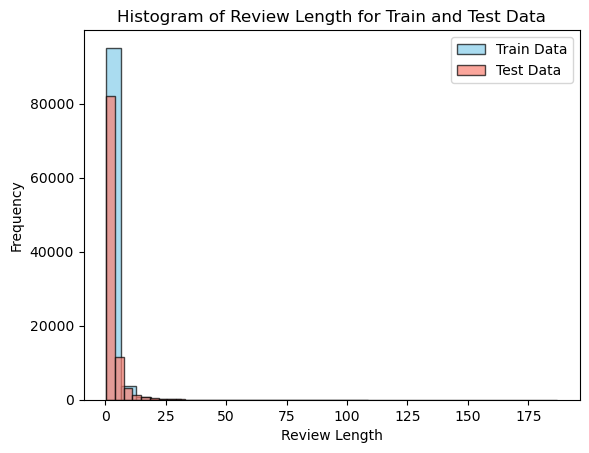

In [155]:
review_length_train = small_df['review_length']
review_length_test = test_df['review_length']

plt.hist(review_length_train, bins=30, color='skyblue', edgecolor='black', alpha=0.7, label='Train Data')
plt.hist(review_length_test, bins=30, color='salmon', edgecolor='black', alpha=0.7, label='Test Data')
# Add labels and title
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.title('Histogram of Review Length for Train and Test Data')
# Add legend
plt.legend()
# Show the plot
plt.show()

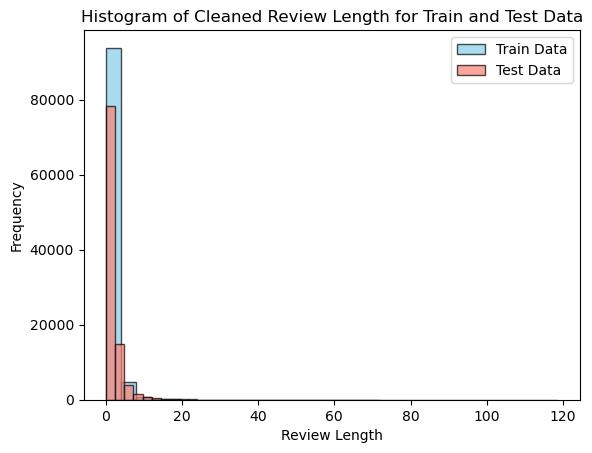

In [156]:
cleaned_review_length_train = small_df['cleaned_review_length']
cleaned_review_length_test = test_df['cleaned_review_length']

plt.hist(cleaned_review_length_train, bins=30, color='skyblue', edgecolor='black', alpha=0.7, label='Train Data')
plt.hist(cleaned_review_length_test, bins=30, color='salmon', edgecolor='black', alpha=0.7, label='Test Data')
# Add labels and title
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.title('Histogram of Cleaned Review Length for Train and Test Data')
# Add legend
plt.legend()
# Show the plot
plt.show()

It looks like the test data and small training data does not look too different. So I decided to go with the Multinomial Naive Bayes classifier trained with the small training data.

In [170]:
# If we transform the trainning data X and test data X separately, we will have different features. 
# Therefore, we need to combine the Xs first and then transform, so that we make sure we are using the same features when we're training, testing, and predicting.

X_small_train = small_df['cleaned_review']
X_real = test_df['cleaned_review']

X2 = pd.concat([X_small_train, X_real])

In [171]:
# Use CountVectorizer to convert the text collection into a matrix of token counts
vectorizer = CountVectorizer()
bow_t2 = vectorizer.fit(X2)
len(bow_t2.vocabulary_)
# Check some of the features
print(bow_t2.get_feature_names_out()[1865])
print(bow_t2.get_feature_names_out()[2782])
X2 = bow_t2.transform(X2)
print('Shape of Sparse Matrix: ', X2.shape)
print('Amount of Non-Zero occurrences: ', X2.nnz)
# Percentage of non-zero values
density2 = (100.0 * X2.nnz / (X2.shape[0] * X2.shape[1]))
print('Density: {}'.format((density2)))

# There are 200000 rows, first 100000 rows are from the small training data, the last 100000 rows are from the test data.

actuellement
aluminium
Shape of Sparse Matrix:  (200000, 51782)
Amount of Non-Zero occurrences:  4713425
Density: 0.04551219535746012


In [177]:
# Now I want to use the first 100000 rows to train models and test models. The last 100000 rows will later be used to predict.
split_index =100000
X3 = X2[:split_index]
X_test_real = X2[split_index:]

In [192]:
random.seed(626)
# 50% as testing
# Y always stays the same 
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X3, Y, test_size=0.5, random_state=101)

In [193]:
from sklearn.naive_bayes import MultinomialNB
nb2 = MultinomialNB()
nb2.fit(X_train2, Y_train2)
preds_Mnb2 = nb2.predict(X_test2)
# let’s evaluate our predictions against the actual ratings using confusion_matrix and classification_report 
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(Y_test2, preds_Mnb2))
print('\n')
print(classification_report(Y_test2, preds_Mnb2))
# Accuracy still 0.48

[[  878   166  1078   400   133]
 [  294   162  1940  1126   167]
 [  184   128  3999  6493   834]
 [   74    49  2366 11999  3170]
 [   66    40   805  6504  6945]]


              precision    recall  f1-score   support

           1       0.59      0.33      0.42      2655
           2       0.30      0.04      0.08      3689
           3       0.39      0.34      0.37     11638
           4       0.45      0.68      0.54     17658
           5       0.62      0.48      0.54     14360

    accuracy                           0.48     50000
   macro avg       0.47      0.38      0.39     50000
weighted avg       0.48      0.48      0.46     50000



In [183]:
# Calculate the R^2
model_Mnb2 = sm.OLS(Y_test2, preds_Mnb2)
result_Mnb2 = model_Mnb.fit()
R_squared_Mnb2 = result_Mnb2.rsquared

# Calculate MSE
MSE_Mnb2 = np.mean((Y_test2 - preds_Mnb2) ** 2)

print("R squared:", R_squared_Mnb2)
print("Mean Squared Error:", MSE_Mnb2)

#R squared: 0.9402916072812455
#Mean Squared Error: 0.93356

R squared: 0.9402916072812455
Mean Squared Error: 0.93356


In [184]:
preds_test_real = nb2.predict(X_test_real)

In [185]:
preds_test_real

array([4, 4, 4, ..., 2, 3, 3], dtype=int64)

In [186]:
len(preds_test_real)

100000

In [187]:
type(preds_test_real)

numpy.ndarray

In [189]:
file_path = "D:/Angie/Grad in UWaterloo/Term 2 W24/ECON626/Prediction Competition/FinalPC/predicted.csv"
np.savetxt(file_path, preds_test_real, delimiter=",")

### In sum, I adopted Multinomial Naive Bayes classifier. My trainning R squared is 0.9402916072812455, training Mean Squared Error is 0.93356. 

# Q2

## Importance of features

In [198]:

# Assuming nb2 is your trained MultinomialNB model

# Get the learned parameters (log probabilities) of the model
log_probabilities = nb2.feature_log_prob_

In [199]:
# Calculate the importance of each feature relative to the most important feature
# We use the maximum log probability across all classes as the reference
max_log_probability = np.max(log_probabilities, axis=0)
relative_importance = np.exp(log_probabilities - max_log_probability)

In [200]:
# Calculate the mean relative importance across all classes for each feature
mean_relative_importance = np.mean(relative_importance, axis=0)

# Sort the features by mean relative importance
sorted_indices = np.argsort(mean_relative_importance)[::-1]
sorted_features = [f"Feature {i}" for i in sorted_indices]

In [202]:
mean_relative_importance

array([0.52880668, 0.81089272, 0.4346155 , ..., 0.669231  , 0.669231  ,
       0.669231  ])

In [204]:
len(mean_relative_importance)
# Since it'll take a while to produce this graph

51782

In [207]:
# Construct a data frame consisting Feature ID and Feature Relative importance
feature_importance_df = pd.DataFrame({
    'Feature ID': sorted_indices,
    'Feature Name': sorted_features,
    'Relative Importance': mean_relative_importance
})
feature_importance_df = feature_importance_df.sort_values(by='Relative Importance', ascending=False)

In [208]:
feature_importance_df.head()

,Feature ID,Feature Name,Relative Importance
41485,43157,Feature 43157,0.978896
15948,20187,Feature 20187,0.968784
12029,38528,Feature 38528,0.962491
16692,23303,Feature 23303,0.957769
43918,31056,Feature 31056,0.953641


In [223]:
feature_importance_df_top100 = feature_importance_df.head(100)

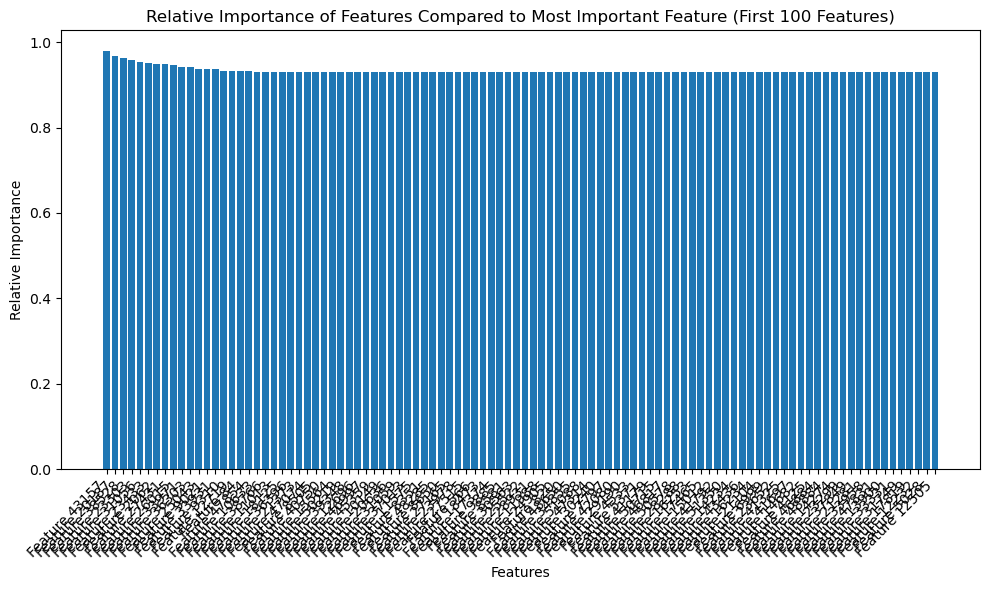

In [227]:
# Plot the relative importance of each feature compared to the most important feature
plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df_top100['Feature Name'], feature_importance_df_top100['Relative Importance'])
plt.xlabel('Features')
plt.ylabel('Relative Importance')
plt.title('Relative Importance of Features Compared to Most Important Feature (First 100 Features)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Correlation between features
I pick the 50 most importance feature and calculate a correlation matrix.

In [240]:
feature_importance_df_top50 = feature_importance_df.head(50)

In [244]:
index_top50 = feature_importance_df_top50["Feature ID"]

In [245]:
X3.shape
index_top50 = np.array(index_top50)
# Select only the columns from X3 whose indexes are in index_top50
X3_top50 = X3[:, index_top50]

In [247]:
X3_top50.shape

(100000, 50)

In [251]:
type(X3_top50)

scipy.sparse._csr.csr_matrix

In [252]:
X3_top50_dense = X3_top50.toarray()

# Calculate the correlation matrix
correlation_matrix = np.corrcoef(X3_top50_dense, rowvar=False)

D:\Installed\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
D:\Installed\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


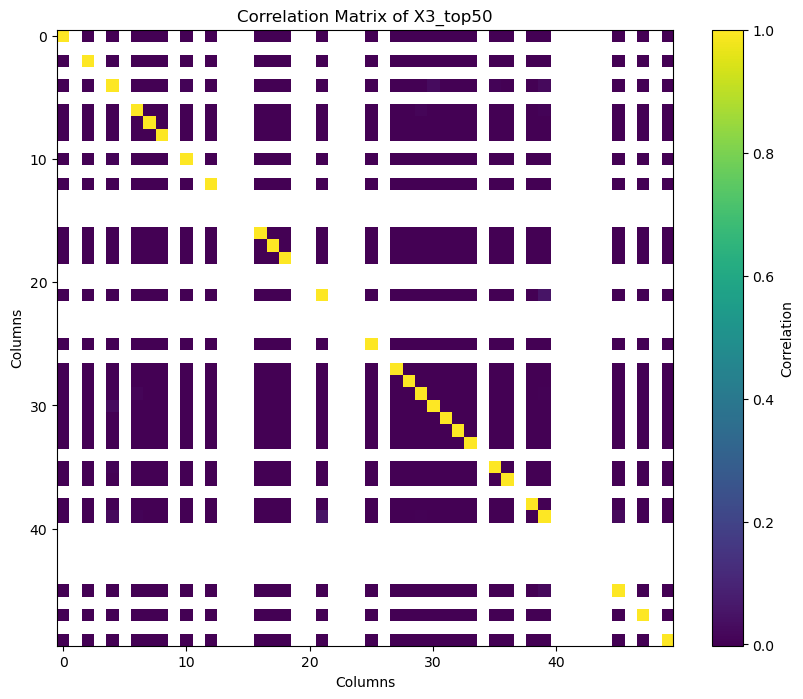

In [254]:
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Correlation')
plt.title('Correlation Matrix of X3_top50')
plt.xlabel('Columns')
plt.ylabel('Columns')
plt.show()
# There are alot of NAs, and those that are not NA are not correlated (Correlation =0)

## Distribution of each feature in the training data versus in the test data
Since here the feature is just the word frequency in each review, we can look at the cleaned review length for a preview

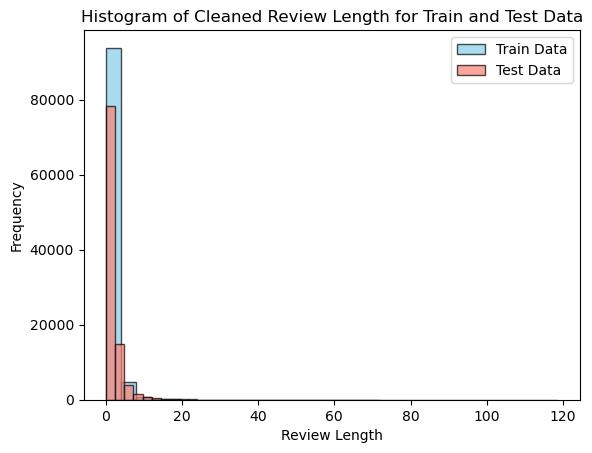

In [228]:
cleaned_review_length_train = small_df['cleaned_review_length']
cleaned_review_length_test = test_df['cleaned_review_length']

plt.hist(cleaned_review_length_train, bins=30, color='skyblue', edgecolor='black', alpha=0.7, label='Train Data')
plt.hist(cleaned_review_length_test, bins=30, color='salmon', edgecolor='black', alpha=0.7, label='Test Data')
# Add labels and title
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.title('Histogram of Cleaned Review Length for Train and Test Data')
# Add legend
plt.legend()
# Show the plot
plt.show()

## Contrast distributions for y vs. ˆy

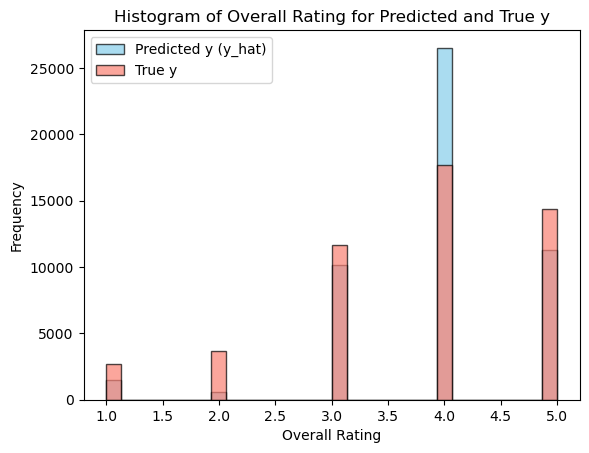

In [229]:
cleaned_review_length_train = small_df['cleaned_review_length']
cleaned_review_length_test = test_df['cleaned_review_length']

plt.hist(preds_Mnb2, bins=30, color='skyblue', edgecolor='black', alpha=0.7, label='Predicted y (y_hat)')
plt.hist(Y_test2, bins=30, color='salmon', edgecolor='black', alpha=0.7, label='True y')
# Add labels and title
plt.xlabel('Overall Rating')
plt.ylabel('Frequency')
plt.title('Histogram of Overall Rating for Predicted and True y')
# Add legend
plt.legend()
# Show the plot
plt.show()

## Word clouds for 5 overall rating levels
Here we use the cleaned_review from small training data to plot the five word clouds.

In [230]:
rating_1 = small_df[small_df['overall_rating'] == 1].copy()
rating_2 = small_df[small_df['overall_rating'] == 2].copy()
rating_3 = small_df[small_df['overall_rating'] == 3].copy()
rating_4 = small_df[small_df['overall_rating'] == 4].copy()
rating_5 = small_df[small_df['overall_rating'] == 5].copy()

In [231]:
rating_1.head()

,overall_rating,firm,date_review,job_title,location,headline,pros,cons,year,review,review_length,cleaned_review,predicted_rating,cleaned_headline,cleaned_pros,cleaned_cons,headline_sentiment,pros_sentiment,cons_sentiment,cleaned_review_length
0,1,WLT-Group,2017-11-20,Team Leader,"Stevenage, England, England",Avoid these idiots,you can leave at any time,no payrises\rno incentive to do well\rIf you d...,2017,Avoid these idiots you can leave at any time n...,1.45,avoid idiot leave time payrises incentive well...,4,avoid idiot,leave time,payrises incentive well if dare opinion bully ...,-0.6705,-0.0516,0.0516,0.75
1,1,ASDA,2019-09-02,Home Delivery Driver,"Dundonald, Northern Ireland, Northern Ireland",Gack pure and utter,"Leaving the store, customers were great even w...","Poor management, awful attitude to they're staff",2019,"Gack pure and utter Leaving the store, custome...",1.54,gack pure utter leaving store customer great e...,4,gack pure utter,leaving store customer great even consent prob...,poor management awful attitude staff,0.0000,0.5106,-0.7269,1.08
2,1,McDonald-s,2019-09-26,Manager,"Dallas, TX",bad pay for how much work i put in,you can steal fries when nobodies looking,if you get caught punishment,2019,bad pay for how much work i put in you can ste...,1.05,bad pay much work put steal fry nobody looking...,4,bad pay much work put,steal fry nobody looking,get caught punishment,-0.5994,-0.4939,-0.4939,0.69
3,1,Adecco,2014-12-09,Technical Lead for IBM,Bangalore,Irresponsible company after joining,Nothing positive about this company,1)After joining and deployed to client locatio...,2014,Irresponsible company after joining Nothing po...,9.06,irresponsible company joining nothing positive...,4,irresponsible company joining,nothing positive company,1 after joining deployed client location they ...,-0.4404,-0.4449,0.6728,6.41
4,1,Grant-Thornton,2020-10-20,Senior Associate,NaN,Discriminate against women in Cyber Risk,The initial pay is what draws you in,This is a place where boys club goes to a whol...,2020,Discriminate against women in Cyber Risk The i...,10.17,discriminate woman cyber risk the initial pay ...,4,discriminate woman cyber risk,the initial pay draw,this place boy club go whole new meaning it ma...,-0.2732,-0.1027,0.7184,5.56


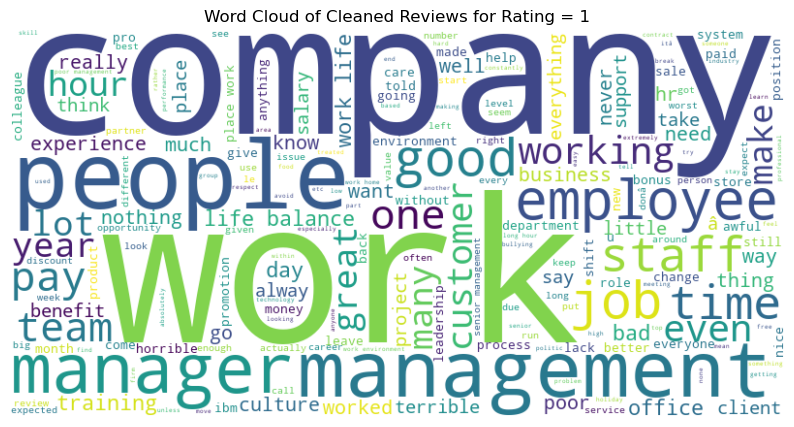

In [264]:
from wordcloud import WordCloud
all_text_1 = ' '.join(rating_1['cleaned_review'].dropna())
# Generate the word cloud
wordcloud_1 = WordCloud(width=800, height=400, background_color='white').generate(all_text_1)
# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Reviews for Rating = 1')
plt.show()

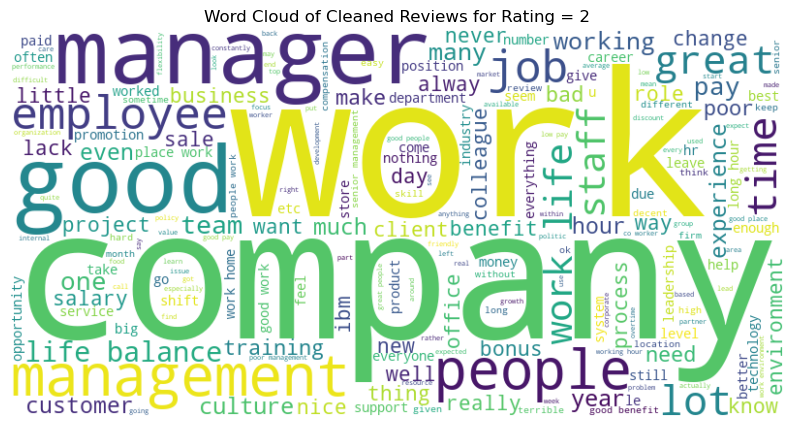

In [236]:
all_text_2 = ' '.join(rating_2['cleaned_review'].dropna())
# Generate the word cloud
wordcloud_2 = WordCloud(width=800, height=400, background_color='white').generate(all_text_2)
# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_2, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Reviews for Rating = 2')
plt.show()

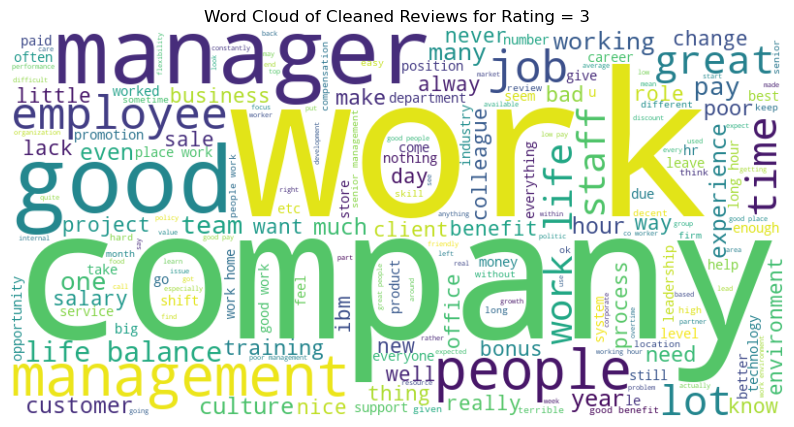

In [239]:
all_text_3 = ' '.join(rating_3['cleaned_review'].dropna())
# Generate the word cloud
wordcloud_3 = WordCloud(width=800, height=400, background_color='white').generate(all_text_3)
# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_2, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Reviews for Rating = 3')
plt.show()

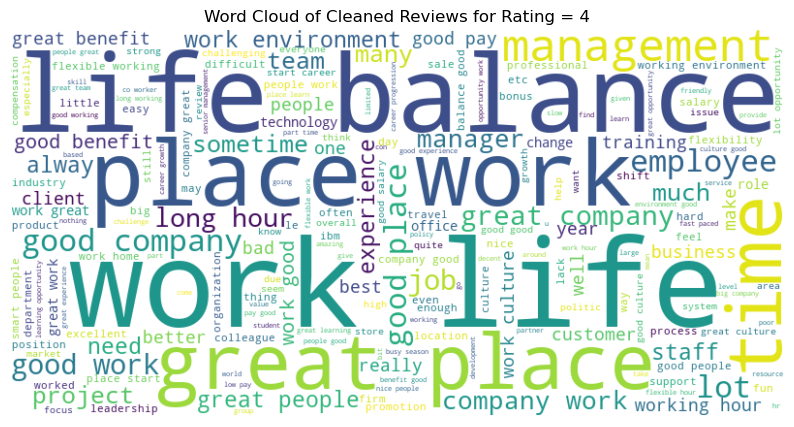

In [238]:
all_text_4 = ' '.join(rating_4['cleaned_review'].dropna())
# Generate the word cloud
wordcloud_4 = WordCloud(width=800, height=400, background_color='white').generate(all_text_4)
# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_4, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Reviews for Rating = 4')
plt.show()

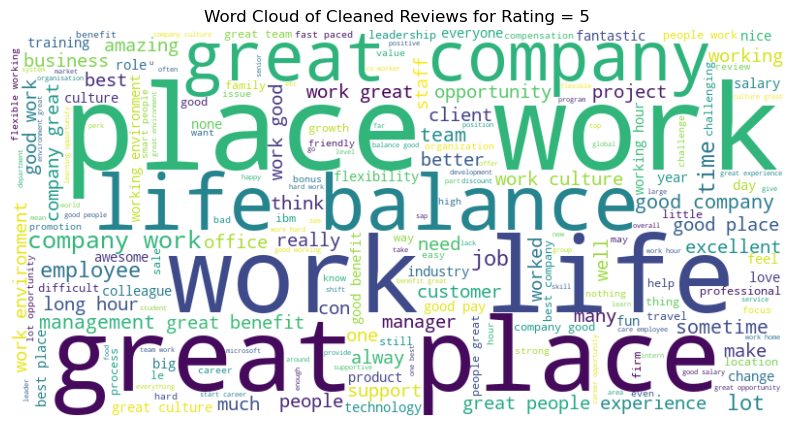

In [237]:
all_text_5 = ' '.join(rating_5['cleaned_review'].dropna())
# Generate the word cloud
wordcloud_5 = WordCloud(width=800, height=400, background_color='white').generate(all_text_5)
# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_5, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Reviews for Rating = 5')
plt.show()

# Q3

To leverage the review data to provide insights on how companies can increase their ratings, we can learn from the highly-rated companies as well as the poorly-rated companies. More specifically, we can look at the headline and pros for companies with ratings over 3 (4 or 5), and also look at the headline and cons for companies with ratings under 3 (1 or 2). To improve the company ratings, the companies should try to adapt some of the practices in the highly-rated companies and try to avoid practies in the poorly-rated companies. 

Below I generated two wordclouds so that we have an overview of those practices.

In [256]:
Q3_good = small_df[small_df['overall_rating'] > 3].copy()
Q3_poor = small_df[small_df['overall_rating'] < 3].copy()

In [258]:
Q3_good.head()

,overall_rating,firm,date_review,job_title,location,headline,pros,cons,year,review,review_length,cleaned_review,predicted_rating,cleaned_headline,cleaned_pros,cleaned_cons,headline_sentiment,pros_sentiment,cons_sentiment,cleaned_review_length
36259,4,Bloomberg-L-P,2015-12-05,Senior Software Engineer,"New York, NY",Amazing Benefits and Culture,- Benefits. The benefits are comparable/somet...,- Career Opportunities. Now this depends on i...,2015,Amazing Benefits and Culture - Benefits. The ...,30.49,amazing benefit culture benefit the benefit co...,4,amazing benefit culture,benefit the benefit comparable sometimes even ...,career opportunity now depends individual goal...,0.7783,0.9841,-0.8979,20.31
36260,4,Deutsche-Bank,2009-07-25,Backoffice,NaN,Good place to work,The bank is very competitive in mainland China...,The compensation is varied greatly according t...,2009,Good place to work The bank is very competitiv...,2.98,good place work the bank competitive mainland ...,4,good place work,the bank competitive mainland china if want le...,the compensation varied greatly according diff...,0.4404,0.6369,-0.3862,2.21
36261,4,CBRE,2019-11-19,Financial Systems Manager,NaN,Manager,Unlimited PTO and good work-life balance.,-Benefits Expensive and No discount stock buy...,2019,Manager Unlimited PTO and good work-life balan...,1.07,manager unlimited pto good work life balance b...,4,manager,unlimited pto good work life balance,benefit expensive no discount stock buying opt...,0.0000,0.4404,0.2023,0.95
36262,4,PwC,2021-03-15,Assurance Associate,Jakarta,-,Very good working environment and human develo...,Worklife balance need to improve,2021,- Very good working environment and human deve...,0.86,very good working environment human developmen...,4,,very good working environment human development,worklife balance need improve,0.0000,0.4927,0.4404,0.78
36263,4,Deloitte,2018-10-05,Anonymous Employee,NaN,Very Professional Environment,Colleagues with high degree of professionalism,Salary is on par with market but Low bonuses,2018,Very Professional Environment Colleagues with ...,1.21,very professional environment colleague high d...,4,very professional environment,colleague high degree professionalism,salary par market low bonus,0.0000,0.0000,0.3400,0.96


In [260]:
Q3_good['good'] = Q3_good['cleaned_headline'].fillna('') + ' ' + Q3_good['cleaned_pros'].fillna('') 
Q3_poor['poor'] = Q3_poor['cleaned_headline'].fillna('') + ' ' + Q3_poor['cleaned_cons'].fillna('') 

In [261]:
Q3_good.head()

,overall_rating,firm,date_review,job_title,location,headline,pros,cons,year,review,...,cleaned_review,predicted_rating,cleaned_headline,cleaned_pros,cleaned_cons,headline_sentiment,pros_sentiment,cons_sentiment,cleaned_review_length,good
36259,4,Bloomberg-L-P,2015-12-05,Senior Software Engineer,"New York, NY",Amazing Benefits and Culture,- Benefits. The benefits are comparable/somet...,- Career Opportunities. Now this depends on i...,2015,Amazing Benefits and Culture - Benefits. The ...,...,amazing benefit culture benefit the benefit co...,4,amazing benefit culture,benefit the benefit comparable sometimes even ...,career opportunity now depends individual goal...,0.7783,0.9841,-0.8979,20.31,amazing benefit culture benefit the benefit c...
36260,4,Deutsche-Bank,2009-07-25,Backoffice,NaN,Good place to work,The bank is very competitive in mainland China...,The compensation is varied greatly according t...,2009,Good place to work The bank is very competitiv...,...,good place work the bank competitive mainland ...,4,good place work,the bank competitive mainland china if want le...,the compensation varied greatly according diff...,0.4404,0.6369,-0.3862,2.21,good place work the bank competitive mainland...
36261,4,CBRE,2019-11-19,Financial Systems Manager,NaN,Manager,Unlimited PTO and good work-life balance.,-Benefits Expensive and No discount stock buy...,2019,Manager Unlimited PTO and good work-life balan...,...,manager unlimited pto good work life balance b...,4,manager,unlimited pto good work life balance,benefit expensive no discount stock buying opt...,0.0000,0.4404,0.2023,0.95,manager unlimited pto good work life balance
36262,4,PwC,2021-03-15,Assurance Associate,Jakarta,-,Very good working environment and human develo...,Worklife balance need to improve,2021,- Very good working environment and human deve...,...,very good working environment human developmen...,4,,very good working environment human development,worklife balance need improve,0.0000,0.4927,0.4404,0.78,very good working environment human development
36263,4,Deloitte,2018-10-05,Anonymous Employee,NaN,Very Professional Environment,Colleagues with high degree of professionalism,Salary is on par with market but Low bonuses,2018,Very Professional Environment Colleagues with ...,...,very professional environment colleague high d...,4,very professional environment,colleague high degree professionalism,salary par market low bonus,0.0000,0.0000,0.3400,0.96,very professional environment colleague high ...


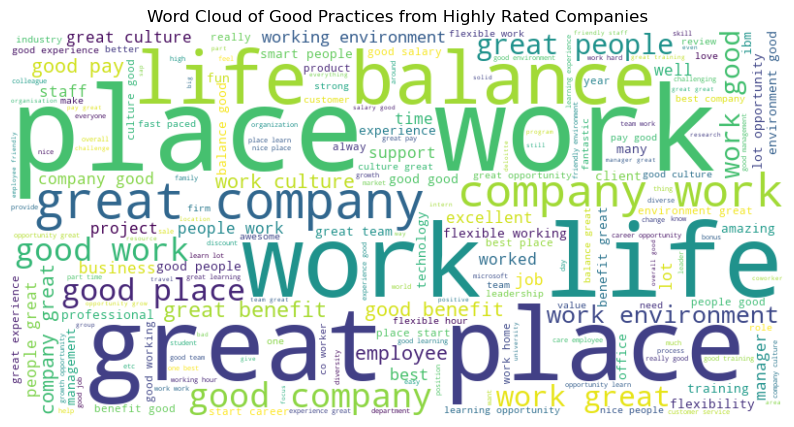

In [262]:
all_text_good = ' '.join(Q3_good['good'].dropna())
# Generate the word cloud
wordcloud_good = WordCloud(width=800, height=400, background_color='white').generate(all_text_good)
# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_good, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Good Practices from Highly Rated Companies')
plt.show()

# From this wordcloud, we can see that some good practices in well rated companies include: great culture, working environment, flexible work, great people, support, lot of opportunity, good benefit

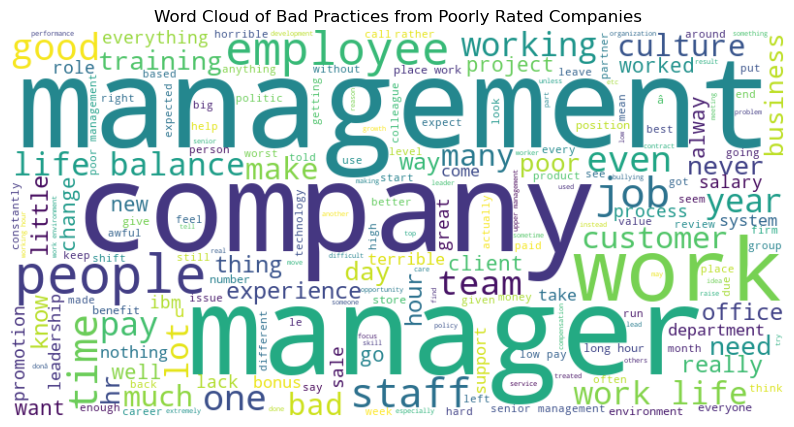

In [263]:
all_text_poor = ' '.join(Q3_poor['poor'].dropna())
# Generate the word cloud
wordcloud_poor = WordCloud(width=800, height=400, background_color='white').generate(all_text_poor)
# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_poor, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Bad Practices from Poorly Rated Companies')
plt.show()

# From this wordcloud we can see some of the reasons for poor ratings include: bad manager, poor management, lack bonus, low pay 